In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import contextlib
import os
from importlib import reload

import torchvision
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'

In [93]:
import renyi
import utils
from renyi import mink_sim_divergence, renyi_mixture_divergence, mink_mixture_divergence, rbf_kernel, poly_kernel, generic_kernel

In [94]:
# torch.set_default_dtype(torch.float64)

class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.LeakyReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [95]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 16, [256, 256]
batch_size = 512

In [105]:
generator = GeneratorFC(z_dim, d, gen_hiddens).cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [116]:
alpha = 1

# emp_probs = 2*torch.ones(1, batch_size//2).cuda()/batch_size
emp_probs = torch.ones(1, batch_size).cuda()/batch_size

kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2]))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: poly_kernel(u, v, degree=2))

# for alpha=1 (REDO!):
# False, False, False: Negative, doesn't work
# False, False, True: Positive, works
# False, True, False: Negative, doesn't work
# False, True, True: Positive, works
# True, False, False: Negative, doesn't work
# True, False, True: Negative, doesn't work
# True, True, False: Negative, doesn't work
# True, True, True: Positive, works
D = lambda x, y: renyi_mixture_divergence(emp_probs, x, emp_probs, y, kernel, alpha,
                                          use_avg=False, use_full=False, symmetric=False)

# for g in g_optimizer.param_groups:
#     g['lr'] = 1e-5

for _ in range(2000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)

        x = x_real[:batch_size//2]
        x_prime = x_real[batch_size//2:]
        y = x_fake[:batch_size//2]
        y_prime = x_fake[batch_size//2:]

#         loss = D(x, y) + D(x_prime, y) + D(x, y_prime) + D(x_prime, y_prime) - 2*D(y, y_prime)
        loss = D(x_real, x_fake)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 0.0774
200 - 0.1265
400 - 0.0686
600 - 0.0797
800 - 0.1140
1000 - 0.1121
1200 - 0.0985
1400 - 0.0613
1600 - 0.1161
1800 - 0.1274


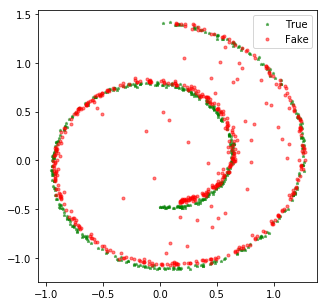

In [117]:
x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
z = torch.randn(500, z_dim).cuda()
x_fake = generator(z).data.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.plot(x_real[:, 0], x_real[:, 1], 'g*', alpha=0.5, label='True', markersize=3)
plt.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake', markersize=3)
plt.legend(loc='best');